# Run AOS on real images

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from flow_analysis_comps.processing.Fourier.OrientationSpaceManager import (
    orientationSpaceManager,
)
import colorcet  # noqa: F401
from flow_analysis_comps.data_structs.AOS_structs import OSFilterParams
from flow_analysis_comps.data_structs.kymographs import (
    graphExtractConfig,
    kymoExtractConfig,
)
from flow_analysis_comps.processing.graph_extraction.graph_extract import (
    VideoGraphExtractor,
)
from flow_analysis_comps.processing.kymographing.kymographer import KymographExtractor
import colorcet as cc

%matplotlib widget

%load_ext autoreload
%autoreload 2


In [ ]:
video_root_folder = Path(
    r"U:\test_data\davis_data\wide_brightfield"
    # r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine\033"
)
graph_data = VideoGraphExtractor(video_root_folder, graphExtractConfig()).edge_data
kymograph_list = KymographExtractor(
    graph_data, kymoExtractConfig()
).processed_kymographs

AOS_params = OSFilterParams(
    space_frequency_center=0.25,
    space_frequency_width=0.3,
    orientation_accuracy=8.0,
    x_spacing=kymograph_list[0].deltas.delta_x,
    y_spacing=kymograph_list[0].deltas.delta_t,
    padding=50,
)
AOS_manager = orientationSpaceManager(AOS_params, kymograph_list[0].kymo_no_static)

angles_dict = AOS_manager.get_all_angles()

In [ ]:
angles_response = AOS_manager.refine_all_angles(4.0, angles_dict)

In [ ]:
from flow_analysis_comps.visualizing.kymographs import kymoVisualizer
from flow_analysis_comps.visualizing.AOSFilterVisualizer import AOSVisualizer

AOS_viz = AOSVisualizer(AOS_params)
AOS_viz.demo_image(AOS_manager)

# Test with test data

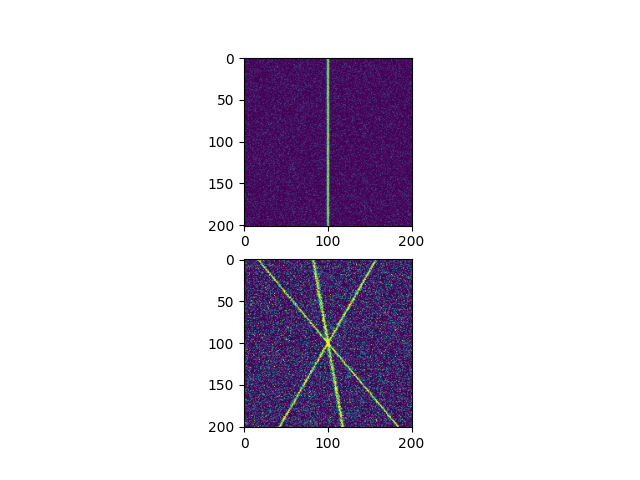

In [ ]:
from flow_analysis_comps.test_data import single_line_img, crossing_line_img
from flow_analysis_comps.util.image_manips import mirror_pad_with_exponential_fade
import numpy as np
import skimage

single_line_angle = 90
multi_line_angles = np.array([50.0, 120.0, 80.0])
imsize = 201

test_single = single_line_img(single_line_angle, std_dev=1, img_size=(imsize, imsize))
test_crossing = crossing_line_img(
    multi_line_angles, [0.8, 1, 1.4], img_size=(imsize, imsize)
)

test_single = skimage.util.random_noise(test_single, mode="gaussian", var=0.01)
test_crossing = skimage.util.random_noise(test_crossing, mode="gaussian", var=0.1)

# test_single = mirror_pad_with_exponential_fade(test_single, pad)
# test_crossing = mirror_pad_with_exponential_fade(test_crossing, pad)

fig, ax = plt.subplots(2)
ax[0].imshow(test_single)
ax[1].imshow(test_crossing)

In [286]:
AOS_params = OSFilterParams(
    space_frequency_center=0.05,
    # space_frequency_width=0.3,
    orientation_accuracy=16,
    x_spacing=1,
    y_spacing=1,
    padding=30,
)

print(AOS_params.nr_of_samples)
AOS_manager = orientationSpaceManager(AOS_params, test_crossing)

filter_arrays = AOS_manager.filter_arrays
print(filter_arrays.shape)


angles_dict = AOS_manager.get_max_angles()
nlms_mask = AOS_manager.nlms_simple_case()

33
(261, 261, 33)


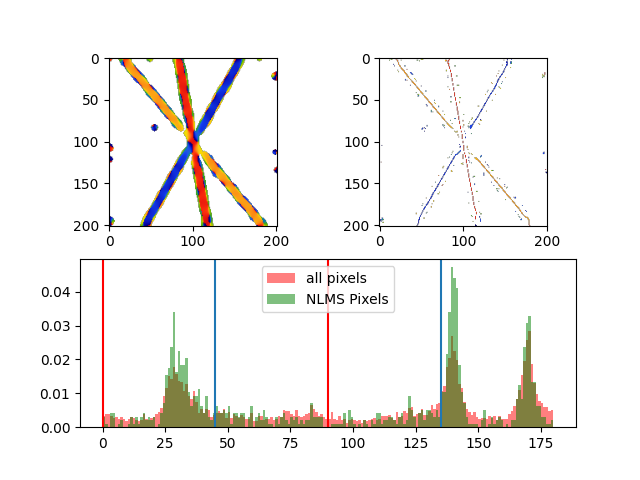

In [287]:
from flow_analysis_comps.visualizing.AOSFilterVisualizer import AOSVisualizer
import numpy as np

full_orientation = np.rad2deg(angles_dict)
nlms_orientation = np.where(nlms_mask, np.rad2deg(angles_dict), np.nan)
# angles_max_max = np.nanmax(angles_dict["angles_maxima"].real, axis=0)
# print(angles_dict.keys())

fig, ax = plt.subplot_mosaic(
    [["Orientation", "NLMS_orientation"], ["Histograms", "Histograms"]]
)
ax["Orientation"].imshow(full_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["NLMS_orientation"].imshow(nlms_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["Histograms"].hist(
    full_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="all pixels",
    color="red",
)
ax["Histograms"].hist(
    nlms_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="NLMS Pixels",
    color="green",
)
ax["Histograms"].axvline(45)
ax["Histograms"].axvline(135)
ax["Histograms"].axvline(single_line_angle, c="red")
ax["Histograms"].axvline((single_line_angle + 90) % 180, c="red")
ax["Histograms"].legend()


In [ ]:
def get_value_from_fft_series(coeffs: np.ndarray, xv: np.ndarray, period: float):
    """
    Sample trigonometric polynomial using the complex fourier series coefficients

    Args:
        coeffs (np.ndarray): Series coefficients
        xv (np.ndarray): Points on which to sample
        period (float): Period of the function

    Returns:
        np.ndarray: Sampled points on trigonometric polynomial
    """

    # Normalize points to a [-1, 1] domain
    xv = xv / period
    size = len(coeffs)

    # adjust the spatial frequencies to period and number of coefficients
    kn = np.fft.fftfreq(size, period / size) * period

    # Sample contributions from each exponential
    eikx = np.exp(2.0j * np.pi * np.outer(xv, kn))

    # Sum and return
    return np.einsum("ab,b->a", eikx, coeffs) / size


def find_extrema(func_fft:np.ndarray, der1_fft: np.ndarray, der2_fft:np.ndarray):
    """
    Finds extrema using companion matrix approach (n fourier coefficients yields n-1 roots). All input arrays need to be of the same size. Values are sorted along the function values to make significant extrema 

    Args:
        func_fft (np.ndarray): Fourier coefficients of original function
        der1_fft (np.ndarray): _description_
        der2_fft (np.ndarray): _description_

    Returns:
        np.ndarray: angles of the function extrema, along with magnitude, sampled function, derivative and second derivative values
    """
    output_depth = len(func_fft) - 1
    coeffs = -np.fft.fftshift(der1_fft)
    # Assemble Matrix
    mat = np.zeros((output_depth, output_depth), dtype=np.complex128)
    mat[:-1, 1:] = np.eye(output_depth - 1)
    mat[-1] = coeffs[:-1] / coeffs[-1]

    eigenvalues = np.linalg.eigvals(mat)
    angles = (np.angle(eigenvalues) - np.log(abs(eigenvalues)) * 1j).real % (
        2 * np.pi
    ) - np.pi

    magnitudes = np.log(abs(eigenvalues))
    origin_values = get_value_from_fft_series(func_fft, angles + np.pi, 2 * np.pi)
    deriv1_values = get_value_from_fft_series(der1_fft, angles + np.pi, 2 * np.pi)
    deriv2_values = get_value_from_fft_series(der2_fft, angles + np.pi, 2 * np.pi)

    sort = np.argsort(origin_values)[::-1]

    return (
        angles[sort],
        magnitudes[sort],
        origin_values[sort],
        deriv1_values[sort],
        deriv2_values[sort],
    )


def filter_angle_outputs(
    angles, magnitudes, origin_values, deriv1_values, deriv2_values
):
    low_magnitude = abs(magnitudes) < 0.05
    low_deriv1 = abs(deriv1_values) < 0.1
    high_deriv2_max = deriv2_values < -6
    high_deriv2_min = deriv2_values > 6
    constraints_score = np.sum([low_magnitude, low_deriv1], axis=0)
    maxima_index = [
        (score == 2) * der2 for score, der2 in zip(constraints_score, high_deriv2_max)
    ]
    minima_index = [
        (score == 2) * der2 for score, der2 in zip(constraints_score, high_deriv2_min)
    ]

    angles_maxima = angles[maxima_index]
    angles_minima = angles[minima_index]
    values_maxima = origin_values[maxima_index]
    values_minima = origin_values[minima_index]
    return (
        angles_maxima,
        angles_minima,
        values_maxima,
        values_minima,
        maxima_index,
        minima_index,
    )


filter_stack = AOS_manager.response.response_stack
filter_stack /= np.max(filter_stack.flatten())

response_shape = filter_stack.shape
response_depth = response_shape[0]
output_depth = response_depth - 1

print(output_depth)

filter_stack_fft = np.fft.fft(filter_stack.real, axis=0)
# filter_stack_fft = filter_stack

nyquist = int(np.ceil((len(filter_stack) + 1) / 2))
print(nyquist)

if response_depth % 2 == 0:
    filter_response_fft = (
        filter_stack_fft.copy()
    )  # Create a copy to avoid modifying the input array
    filter_response_fft[nyquist - 1] /= 2
    filter_response_fft = np.insert(
        filter_response_fft, nyquist, filter_response_fft[nyquist - 1], axis=0
    )
    filter_stack_fft = filter_response_fft
    output_depth = output_depth + 1

response_frequencies = np.concatenate(
    [np.arange(nyquist), -np.arange(nyquist - 1, 0, -1)]
)
response_frequencies_full = response_frequencies[
    ..., np.newaxis, np.newaxis
]  # Add new axis for broadcasting
response_angles = AOS_manager.response.range_of_angles / np.pi * 180
freq_axis = np.fft.fftshift(response_frequencies)

response_fft_derivative1 = filter_stack_fft * (1j * response_frequencies_full)
response_fft_derivative2 = filter_stack_fft * -(response_frequencies_full**2)

function_flat = np.reshape(np.moveaxis(filter_stack_fft, 0, 2), (-1, response_depth))
derivat1_flat = np.reshape(
    np.moveaxis(response_fft_derivative1, 0, 2), (-1, response_depth)
)
derivat2_flat = np.reshape(
    np.moveaxis(response_fft_derivative2, 0, 2), (-1, response_depth)
)

print(function_flat.shape)

output_dict = {
    "maxima": np.full((function_flat.shape[0], output_depth), fill_value=np.nan),
    "minima": np.full((function_flat.shape[0], output_depth), fill_value=np.nan),
    "values_max": np.full((function_flat.shape[0], output_depth), fill_value=np.nan),
    "values_min": np.full((function_flat.shape[0], output_depth), fill_value=np.nan),
}

# sample_coeffs = -np.fft.fftshift(response_fft_derivative1[:, 30, 30])

for i, (func, der1, der2) in enumerate(
    zip(function_flat, derivat1_flat, derivat2_flat)
):
    angles, magnitudes, origin_values, deriv1_values, deriv2_values = find_extrema(
        func, der1, der2
    )

    angles_maxima, angles_minima, values_maxima, values_minima, _, _ = (
        filter_angle_outputs(
            angles, magnitudes, origin_values, deriv1_values, deriv2_values
        )
    )

    output_dict["maxima"][i, : len(angles_maxima)] = angles_maxima.real
    output_dict["minima"][i, : len(angles_minima)] = angles_minima.real
    output_dict["values_max"][i, : len(values_maxima)] = values_maxima.real
    output_dict["values_min"][i, : len(values_minima)] = values_minima.real

for key, item in output_dict.items():
    output_dict[key] = np.reshape(item.T, (output_depth, *filter_stack.shape[1:]))
roots_out_img = output_dict["maxima"]
print(roots_out_img.shape)

# print(np.rad2deg(angles_filtered))
# print((multi_line_angles + 90) % 180)
# print(constraints_score)

32
17
(40401, 33)
(32, 201, 201)


[152, 69] values: [ 0.71177239  0.70901814  0.04092192  0.02985136  0.02762224  0.02719265
  0.01691578  0.01653891  0.01447954  0.00991677  0.00990641  0.00950051
  0.00914871  0.00704581  0.00635444  0.00166889  0.00084349 -0.00721679
 -0.00907595 -0.00926338 -0.01134026 -0.01137348 -0.01176932 -0.0121353
 -0.01254047 -0.01417577 -0.01474885 -0.02622753 -0.02640425 -0.03194203
 -0.03758382 -0.03866844]
[192, 75] values: [ 6.53105434e-02  6.49407655e-02  5.62357694e-02  4.78587498e-02
  3.49625178e-02  2.17657519e-02  1.68422633e-02  1.60776343e-02
  1.47193173e-02  1.36821100e-02  1.34849947e-02  1.34086252e-02
  1.30848343e-02  1.30232012e-02  1.23223899e-02  9.65278702e-03
  2.73964845e-04  4.44883556e-06 -1.68751449e-02 -1.74710091e-02
 -1.88778748e-02 -1.96185106e-02 -2.00176010e-02 -2.09002560e-02
 -2.30828208e-02 -2.51612500e-02 -2.66127206e-02 -2.66269691e-02
 -2.84161538e-02 -2.89377064e-02 -2.89555657e-02 -4.58676944e-02]


C:\Users\night\AppData\Local\Temp\ipykernel_19428\1431692017.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()
C:\Users\night\AppData\Local\Temp\ipykernel_19428\1431692017.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


(-3.141592653589793, 3.141592653589793)

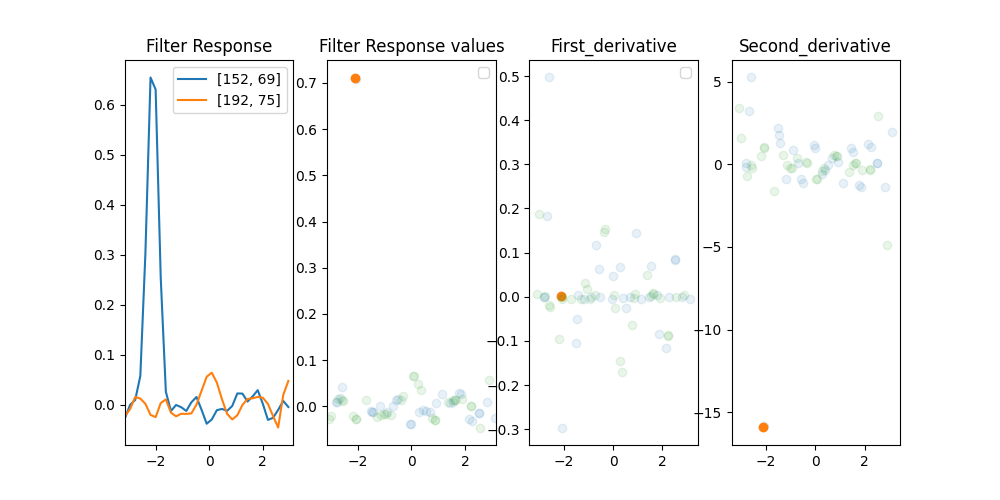

In [ ]:
points = [
    # [40, 90],
    [152, 69],
    # [100, 100],
    [192, 75],
]

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].set_title("Filter Response")
ax[1].set_title("Filter Response values")
ax[2].set_title("First_derivative")
ax[3].set_title("Second_derivative")

for point in points:
    function_vals = np.fft.ifft(filter_stack_fft[:, *point])

    angles, magnitudes, origin_values, deriv1_values, deriv2_values = find_extrema(
        filter_stack_fft[:, *point],
        response_fft_derivative1[:, *point],
        response_fft_derivative2[:, *point],
    )
    print(f"{point} values: {origin_values[:].real}")
    angles_maxima, angles_minima, values_maxima, values_minima, max_idx, min_idx = (
        filter_angle_outputs(
            angles, magnitudes, origin_values, deriv1_values, deriv2_values
        )
    )

    ax[0].plot(
        np.linspace(-np.pi, np.pi, response_depth, endpoint=False),
        function_vals.real,
        label=f"{point}",
    )
    ax[1].scatter(angles, origin_values, alpha=0.1)
    ax[1].scatter(angles_maxima, abs(values_maxima))
    ax[2].scatter(angles, deriv1_values, alpha=0.1)
    ax[2].scatter(angles_maxima, deriv1_values[max_idx])
    ax[3].scatter(angles, deriv2_values, alpha=0.1)
    ax[3].scatter(angles_maxima, deriv2_values[max_idx])

# ax[2].imshow(function_flat[1800:1900].real)
ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim(-np.pi, np.pi)
ax[1].set_xlim(-np.pi, np.pi)
# ax[1].set_yscale('log')

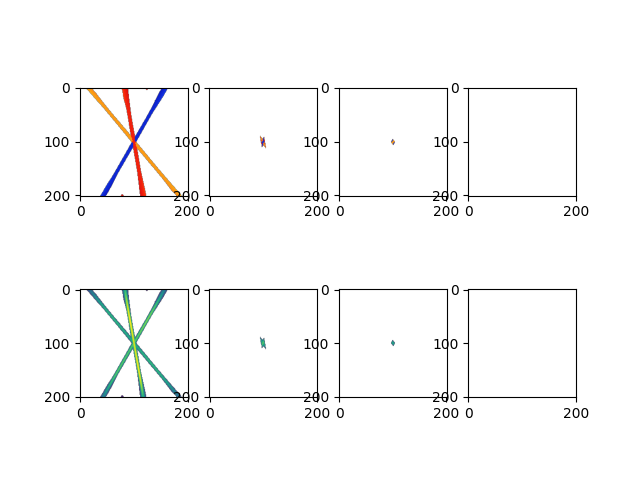

In [ ]:
angles_im = output_dict["maxima"]
values_im = output_dict["values_max"]


fig, ax = plt.subplots(2, len(roots_out_img[:4]))
for i, im in enumerate(roots_out_img[:4]):
    ax[0, i].imshow(im.real, cmap=cc.cm.rainbow4, vmin=-np.pi, vmax=np.pi)
    ax[1, i].imshow(values_im[i], vmin=0, vmax=1)
    # ax[2, i].imshow(np.angle(im), vmin=-np.pi, vmax=np.pi)
    # ax[3, i].imshow(abs(np.log(abs(im))) < 0.001)

In [291]:
# print(response_fft_derivative1[:, *points[0]])
sequence_fft = response_fft_derivative1[:, *points[2]]

N = len(sequence_fft)
K = N // 2
c = np.fft.fftshift(sequence_fft)

c /= c[-1]
n = N
companion = np.zeros((n, n), dtype=np.complex128)
companion[1:, :-1] = np.eye(n - 1, dtype=np.complex128)
companion[0, 1:] = c[:-1][::-1]
roots = np.linalg.eigvals(companion)
magnitudes = abs(roots)

angles = np.log(roots)
angles = np.rad2deg(np.angle(angles * -1j / 2))
# angles = np.where(abs(np.log(magnitudes)) < .9, angles, -1)
print(companion)
print(angles)
print(magnitudes)

IndexError: list index out of range

In [ ]:
angles_all = AOS_manager.get_all_angles()
angles_max = np.nanmax(angles_all["maxima_value"], axis=0)

ValueError: operands could not be broadcast together with shapes (33,201,201) (17,1,1) 

In [ ]:
plt.figure()
plt.imshow(
    np.rad2deg(angles_all["angles_maxima"][0]), vmin=0, vmax=360, cmap=cc.cm.rainbow4
)